## Import Libraries

In [1]:
import numpy as np
import math
import cv2   
import matplotlib.image as image
import matplotlib.pyplot as plt
from matplotlib import pyplot


## Generation of Masks

In [2]:
def HalfMask(T,sigma):
    sHalf=np.round(math.sqrt(-np.log(T)*2*(np.square(sigma)))) # formula to compute the half mask size
    return sHalf
def calculate_filter_size(T,sigma):
    return 2*HalfMask(T,sigma)+1 # calculating size of filter 

In [3]:
def Generate_Mask(T,sigma,shalf):
     x1=range(- int (shalf),int (shalf)+1) # Setting range for x1
     y1=range(- int (shalf),int (shalf)+1) # Setiing range for y1
     y,x = np.meshgrid (x1,y1) # meshgrid function to generate mask a rectangular grid of 2 one dimesnional arrays
     return x,y

In [4]:
def apply_Gaussain(x,y,sigma):
     z1=((x**2)+(y**2))
     z2= 2*(sigma**2)
     return np.exp(-(z1/z2)) # Gaussian derivative in steps
def x_derivative(x,y,sigma):
     return -((x * (apply_Gaussain(x,y,sigma)))/np.square(sigma)) # Gaussian derivative w.r.t to x
def y_derivative(x,y,sigma):
      return -((y* (apply_Gaussain(x,y,sigma)))/np.square(sigma)) #Gaussian derivative w.r.t to y
def x_secondderivative(x,y,sigma):
      return ( ((x**2)-(sigma**2))*(apply_Gaussain(x,y,sigma)))/(sigma**4) #Gaussian derivative w.r.t to y
def y_secondderivative(x,y,sigma):
      return ( ((y**2)-(sigma**2))*(apply_Gaussain(x,y,sigma)))/(sigma**4) #Gaussian derivative w.r.t to y

In [5]:
def Scalingup_gradients(gxy):
     return np.round(gxy*255.0) #Scaling up all gradients results with 255

## Applying Masks to the images

In [6]:
def convert_grayscale(img):
    gray_img = np.round(0.299 * img[:, :, 0] +
                    0.587 * img[:, :, 1] +
                    0.114 * img[:, :, 2]).astype(np.uint8) # converting image to grayscale
    return gray_img

In [7]:
def ImageSmoothing(img,mask):
  if (len(img.shape) > 2):
        img=convert_grayscale(img)
  i_h,i_w= img.shape # height and width of image
  m_h,m_w= mask.shape # height and width of mask  
  pad =(m_w-1)//2 # pading the borders of image
  img=cv2.copyMakeBorder(img,pad,pad,pad,pad,cv2.BORDER_REPLICATE)
  outputimg=np.zeros((i_h,i_w)) # set the size of output according to the image
  for y in range(i_h):  # concolving around the image to apply filter/ mask 
        for x in range(i_w):
              outputimg[y,x]=np.sum((mask * img[y:y+m_h, x:x+m_w]))
  return outputimg

In [8]:
def apply_mask(img,mask):
  if (len(img.shape) > 2):
        img=convert_grayscale(img)
  i_h,i_w= img.shape # height and width of image
  m_h,m_w= mask.shape # height and width of mask  
  pad =(m_w-1)//2 # pading the borders of image
  img=cv2.copyMakeBorder(img,pad,pad,pad,pad,cv2.BORDER_REPLICATE)
  outputimg=np.zeros((i_h,i_w)) # set the size of output according to the image
  for y in range(i_h):  # concolving around the image to apply filter/ mask 
        for x in range(i_w):
              outputimg[y,x]=np.sum((mask * img[y:y+m_h, x:x+m_w]))
  return outputimg

## Compute Gradient Magnitude

In [9]:
def Magnitude_of_Gradient(fx,fy):
      return np.sqrt((np.square(fx))+(np.square(fy))) # Formula for computing gradient magnitude

In [10]:
def scaledown_Gradients(x):
    min = np.amin(x)
    max = np.amax(x)
    SC = (x - min) * 255.0 / (max - min) # formula to scale down the gradients between 0 and 255
    SC = np.uint8(SC)
    return SC

## Compute Gradient Direction

In [11]:
def Gradients_Direction(fx,fy):
    return (np.rad2deg(np.arctan2(fy, fx))) + 180 # formula to compute gradients direction

# Non-Maximum-Supresion 
Three steps:\
1-Quantization\
2-Color Quantization\
3-Non-Maximum-Supression

### Quantization

In [12]:
def Quantization(D):
    h,w=D.shape[0],D.shape[1] # Gradient Direction  shape
    Q = np.zeros((h,w)) # create new matrix of same shape
    for x in range(h): # Moving into gradient direction matrix
        for y in range(w):
            if (0 <= D[x, y] <= 22.5) or (157.5 <= D[x, y] <= 202.5) or (337.5 < D[x, y] < 360):
                Q[x, y] = 0 # 0  if exist between to 22.5 157.5 to 202.5 337.5 to 360
            elif (22.5 <= D[x, y] <= 67.5) or (202.5 <= D[x, y] <= 247.5):
                Q[x, y] = 1 # 1 if exists between  22.5 to 67.5 or 202.5 to 247.5
            elif (67.5 <= D[x, y] <= 122.5) or (247.5 <= D[x, y] <= 292.5):
                Q[x, y] = 2 # 2 if exists between 67.5 to 112.5 or 247.5 to 292.5
            elif (112.5 <= D[x, y] <= 157.5) or (292.5 <= D[x, y] <= 337.5):
                Q[x, y] = 3 # 3 if exists between 112.5 to 157.5  or 292.5 to 337.5
    return Q

### Color Quantization

In [13]:
def Color_Quantization(Q,M):   # Q for quantization and M for Magnitude
    h,w=M.shape[0],M.shape[1]
    CQ= np.zeros((h,w,3), np.uint8) # CQ  for color Quantization matrix
    for x in range(h-1):
        for y in range(w-1):
            if Q[x,y] == 0: # check pixel at Q is 0
                if M[x,y] != 0: #and Magnitude is not equal to zero
                   CQ[x,y,0] =255 # make color quantization 255 at channel 0
                else:
                     CQ[x,y,0] =0 
            if Q[x,y] == 1: # check pixel at Q is 0
                if M[x,y] != 0: #and Magnitude is not equal to zero
                   CQ[x,y,1]=255# make color quantization 255 at channel 1
                else:
                   CQ[x,y,1]=  0
            if Q[x,y] == 2: # check pixel at Q is 0
                if  M[x,y] != 0: #and Magnitude is not equal to zero
                    CQ[x,y,2]=255 # make color quantization 255
                else:
                     CQ[x,y,2]=0
            if Q[x,y] == 3:# check pixel at Q is 0
                if  M[x,y] != 0: #and Magnitude is not equal to zero
                    CQ[x,y,0]=255 # make color quantization 255 at channel 0
                    CQ[x,y,1]= 255 # make color quantization 255 at channel 1
                    
                else:
                    CQ[x,y,0]= 0
                    CQ[x,y,1]= 0
    return CQ

## Non-Maximum-Supression

In [14]:
def Non_Max_Suppression(Q,D,M):
    h,w=Q.shape[0],Q.shape[1]
    MS = np.zeros((h,w))# make new matrix same size of Quantization matrix
    for x in range(h-1): # Moving through pixels
        for y in range(w-1):
            if Q[x,y] == 0: #Check the value if it is in O bin or angle 
                if  (M[x,y-1]< M[x,y]) or( M[x,y] > M[x,y+1]): #Check the Magnitude left and right value of pixel if it is maximum put its direction in new matrix
                    MS[x,y] = D[x,y] #Set the value of its direction in the new matrix
                else:
                     MS[x,y] = 0
            if Q[x,y]==1: # check the value if its is in bin 45 
                if  (M[x-1,y+1]<= M[x,y]) or (M[x,y] >= M[x+1,y-1]): # check the pixel values in the diagonal
                     MS[x,y] = D[x,y] # if it s maximum put the value over here
                else:
                     MS[x,y] = 0     # otherwise make that pixel 0 
            if Q[x,y] == 2: # check the value if it is in bin 90
                if  (M[x-1,y]<= M[x,y]) or( M[x,y] >= M[x+1,y]): # Check the pixel values up and down side
                     MS[x,y] = D[x,y] #If its maximum store its angle value
                else:
                     MS[x,y] = 0 # otherwise 0
            if Q[x,y] == 3: # check if the value is in bin 135
                if  (M[x-1,y-1]<= M[x,y]) or (M[x,y] >= M[x+1,y+1]): # if in the bin check its opposite digonal values of the pixel
                     MS[x,y] = D[x,y] # if its maximum store its angle value
                else:
                     MS[x,y] = 0 # otherwise zero
    return MS

## Hysteresis Thresholding

In [15]:
def Hystereisis_Thresholding(MS,min_TH,max_TH): # MS is minimum supression, min_TH is minimum threshold and max_TH is maximum threshold
    MS_h, MS_w = MS.shape[0],MS.shape[1]
    TSD = np.zeros((MS_h,MS_w))
    for x in range(0,MS_h):#loop over pixels
        for y in range (0,MS_w):
            if MS [x,y] < min_TH:
                 TSD[ x,y ] = 0 # lower than minimum threshold
            elif (MS [x,y] >= min_TH) and  (MS [x,y] < max_TH): 	# between thresholds
                   TSD[ x,y ] = 128
            else:					        # higher than maximum threshold
                   TSD[ x,y ] = 255
    h,w=TSD.shape[0],TSD.shape[1]
    S_edge = np.zeros((h,w)) # G_edge to look for strong edge 
    for x in range(0,h):	# Check each pixel
        for y in range(0, w):
            res_v = TSD[x,y]
            if res_v == 128:			# checking  strong edge on the basis of criteria 
                if (TSD[x-1,y] == 255) or(TSD[x+1,y] == 255) or (TSD[x-1,y-1] == 255 ) or( TSD[x+1,y-1] == 255) or (TSD[x-1,y+1] == 255) or( TSD[x+1,y+1] == 255) or (TSD[x,y-1] == 255) or( TSD[x,y+1] == 255):
                    S_edge[x,y] = 255		# if weak edge found replace it
            elif res_v == 255:
                   S_edge[x,y] = 255		# if the edge is strong keep it
    return TSD,S_edge

## Reading all Images

In [16]:
circle=cv2.imread("circle.jpg")
xray=cv2.imread("xray.tif")
ctscan=cv2.imread("ctscan.tif")
mecca=cv2.imread("mecca06.jpg")
shape=cv2.imread("shapessm.jpg")
wallLahore=cv2.imread("wallLahoreFortBBC .jpg")


# Main Function

In [17]:
def CannyEdgeDetection(img,T,sigma,min_TH,max_TH):
      sHalf=HalfMask(T,sigma)
      fiter_size=calculate_filter_size(T,sigma) # Function to specify the filter size
      X,Y=Generate_Mask(T,sigma,sHalf)# Generating X and Y mask
      Gauss=apply_Gaussain(X,Y,sigma) # Gausian filter for Smoothing
      Gx=x_derivative(X,Y,sigma) # Gaussian derivative w.r.t x
      Gy=y_derivative(X,Y,sigma)# Gaussain derivative w.r.t y
      gx=Scalingup_gradients(Gx) # Scaling up x derivative value so that convolution is performed on integer value rather than float 
      gy=Scalingup_gradients(Gy) # Scaling up y derivative value so that convolution is performed on integer value rather than float
      fig, ax = plt.subplots(3,3,figsize=(20,20)) # function to plot subplots
      g_img=convert_grayscale(img) # First converting the image to grayscale if has three chanels
      ax[0,0].imshow(img)
      ax[0,0].set_title("original Image") # Plot of Original Image
      smooth_img=ImageSmoothing(img,Gauss) # Function apply smoothing using Gaussian filter
      ax[0,1].imshow(-smooth_img,cmap='gray')
      ax[0,1].set_title("Image after Smoothing") # Plot of Smooth image
      fx=apply_mask(smooth_img,gx) # Function to convolve over Smooth image using fx 
      ax[0,2].imshow(fx,cmap='gray') # plot of fx 
      ax[0,2].set_title('fx')
      fy=apply_mask(smooth_img,gy)# Function to convolve over Smooth image using fy
      ax[1,0].imshow(fy,cmap='gray')  # plot of fy
      ax[1,0].set_title('fy')
      M= Magnitude_of_Gradient(fx,fy) # Function to find the magnitude of Gradients
      M=scaledown_Gradients(M) # function to normalize the magnitude between 0 and 255
      #cv2.imwrite("wallLahoreFortBBC_magnitude_1.jpg",M)
      ax[1,1].imshow(M ,cmap='gray')
      ax[1,1].set_title('Magnitude of Gradient') # Plot Display Gradient Magnitude
      D=Gradients_Direction(fx,fy) # Function to find the gradients Direction
      Q=Quantization(D) # Function to Do quantization to perform Non-Maximum-Supression
      CQ= Color_Quantization(Q,M) # Function for color Quantization
      #pyplot.imsave("wallLahoreFortBBC_colorquantized_1.jpg",CQ)
      ax[1,2].imshow(CQ)
      ax[1,2].set_title('Color Quantization') #Plot of colored Quantization
      MS=Non_Max_Suppression(Q,M,D) # Non-Maximum-Supression
     # cv2.imwrite("wallLahoreFortBBC_NonMaximumSupression_1.jpg",MS)
      ax[2,0].imshow(MS,cmap='gray')
      ax[2,0].set_title('Non-Maximum-Suppression') #Plot of Non-Maximum-Supression
      TSD,S_edge=Hystereisis_Thresholding(MS,min_TH,max_TH) # Function for Hysteresis
      ax[2,1].imshow(TSD ,cmap='gray') 
      ax[2,1].set_title('Thresholding Results')
      #cv2.imwrite("CompwallLahore_Th_1.jpg",TSD)
      ax[2,2].imshow(S_edge,cmap='gray')
      ax[2,2].set_title('Hysteresis Results')
      #cv2.imwrite("CompctwallLahore_TI_1.jpg",S_edge)
       #circle_NonMaxsupression_0.5
    
      

## Instruction to run the code:
1. Specify arguments in function below named as CannyEdgeDectector (image,T,sigma,MinThreshold,MaxThreshold).
2. Loaded_Images are saved with Variable names as:
   1. circle
   2. mecca
   3. xray
   4. ctscan
   5. wallLahore
   6. shape
3. To load any other image please first read and save the image in a variable in section
    Reading all Images.
4. Below given function will run whole program and display plots. you can find edges of any image using CannyEdgedectector function.   

5. Restart and Run all jupyter notebook to see the results.



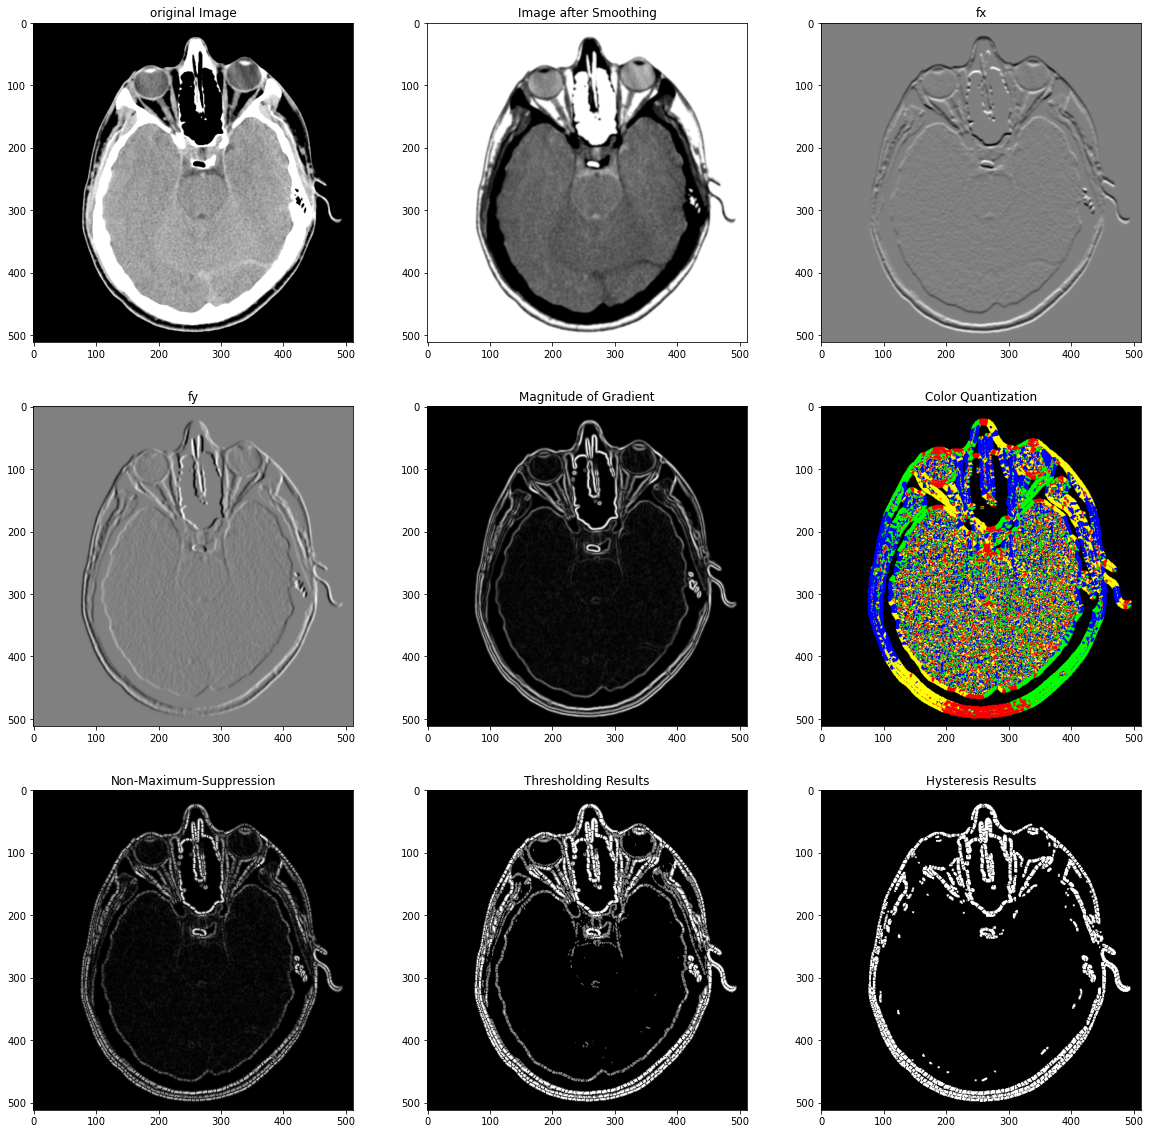

In [19]:
CannyEdgeDetection(ctscan,0.3,1,30,100)
#CannyEdgeDectector (image,T,sigma,MinThreshold,MaxThreshold)

## Mathematical Part
Plots of Gaussian first and Second derivatives for one Dimension

#### Plot of simple Guassian

In [20]:
def Gaussian_DoubleDerivative(x,y,sigma):
    return  ((x*y)/2*np.pi*(sigma**6))*(apply_Gaussain(x,y,sigma))

(100, 100)


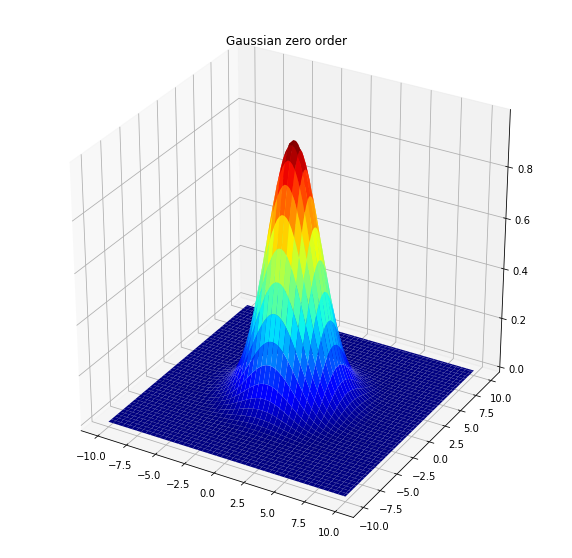

In [21]:
# import for colormaps
from matplotlib import cm
sigma=2
x=np.linspace(-10,10, num=100)
y=np.linspace(-10,10, num=100)

x, y = np.meshgrid(x, y)

z = apply_Gaussain(x,y,sigma)
print(z.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z, cmap=cm.jet)
ax.set_title("Gaussian zero order")
plt.show()

(100, 100)


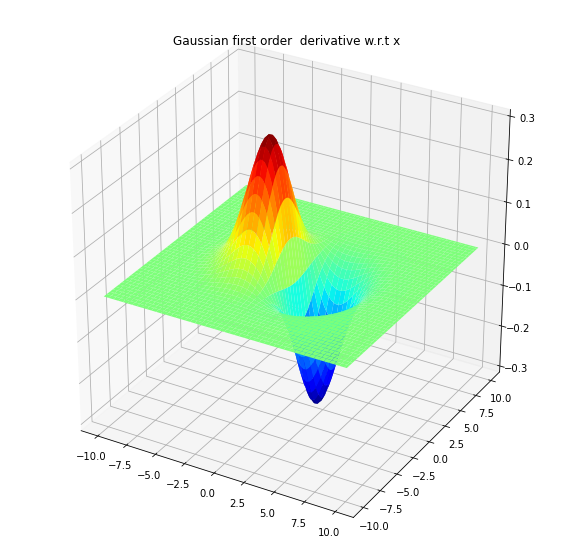

In [22]:
z1 = x_derivative(x,y,sigma)
print(z.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z1, cmap=cm.jet)
ax.set_title("Gaussian first order  derivative w.r.t x")
plt.show()

(100, 100)


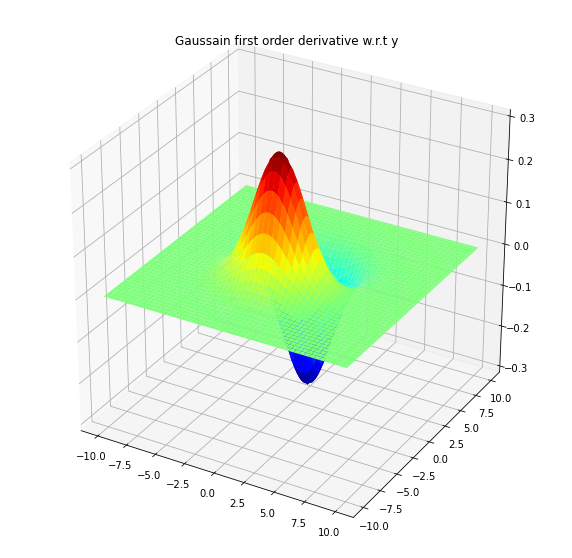

In [23]:
z2 = y_derivative(x,y,sigma)
print(z.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z2, cmap=cm.jet)
ax.set_title("Gaussain first order derivative w.r.t y")
plt.show()

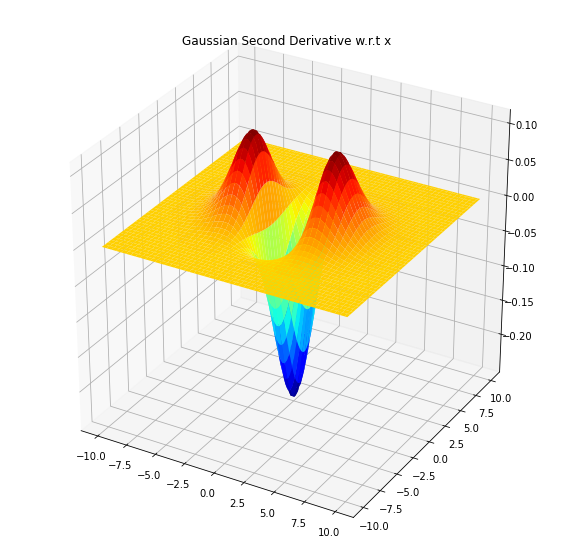

In [24]:
z3=x_secondderivative(x,y,sigma)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z3, cmap=cm.jet)
ax.set_title("Gaussian Second Derivative w.r.t x")
plt.show()

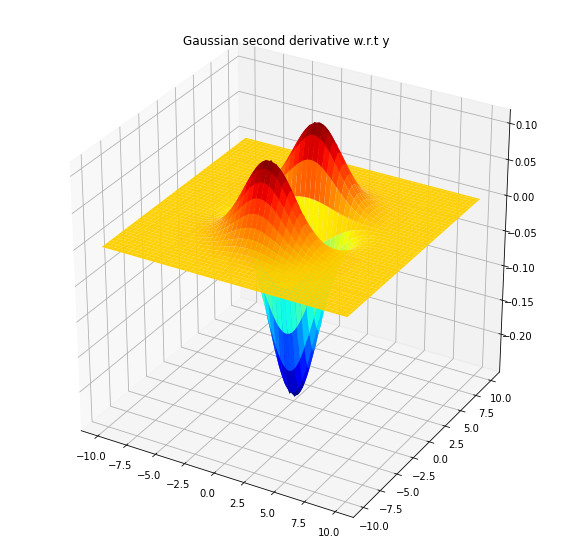

In [25]:
z4=y_secondderivative(x,y,sigma)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z4, cmap=cm.jet)
ax.set_title("Gaussian second derivative w.r.t y")
plt.show()

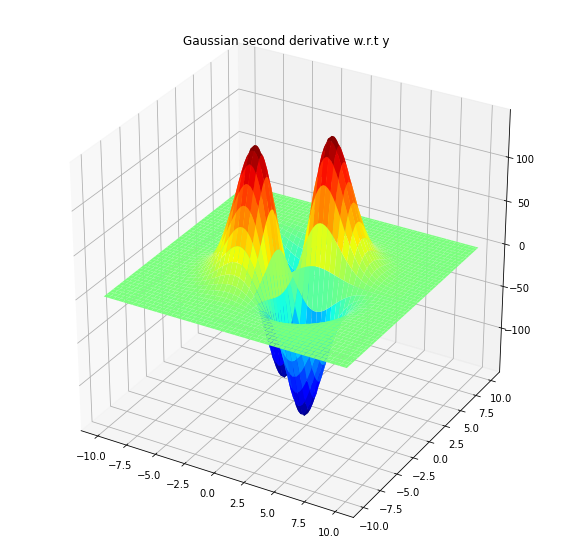

In [29]:
z5=Gaussian_DoubleDerivative(x,y,sigma)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z5, cmap=cm.jet)
ax.set_title("Gaussian second derivative w.r.t y")
plt.show()